## Read in processed data from the Boston master merger notebook

In [1]:
# This will take several mintues to run. Kick back and relax. Or this is a good time to get a cup of coffee.
%run Boston_311_Master_Merger.ipynb



Holy cow! I hope you got coffee during the runtime: 0:05:54.022815


In [10]:
# Examine the shape the master dataframe from the merged ipynb
print('Number of Rows: ', master.shape[0])
print('Number of Columns: ', master.shape[1])

Number of Rows:  1864760
Number of Columns:  12


In [11]:
# Explore the fields and values from the master dataframe to determine what fields we will need for ML
pd.set_option('display.max_columns', None)
master.head()

,case_enquiry_id,date,ontime,case_status,subject,reason,avgprcp,Total_P1,GEOID20,ucr_one,ucr_two,total_ucr
0,101001409422,2015-06-15,ONTIME,Closed,Public Works Department,Sanitation,102.0,2120.0,2.502511e+11,101.0,436.0,537.0
1,101001409423,2015-06-15,ONTIME,Open,Animal Control,Animal Issues,102.0,1033.0,2.502510e+11,83.0,294.0,377.0
2,101001409424,2015-06-15,OVERDUE,Open,Public Works Department,Highway Maintenance,102.0,1872.0,2.502512e+11,116.0,444.0,560.0
3,101001409425,2015-06-15,OVERDUE,Closed,Public Works Department,Highway Maintenance,102.0,610.0,2.502507e+11,617.0,1644.0,2261.0
4,101001409429,2015-06-15,ONTIME,Open,Animal Control,Animal Issues,102.0,1354.0,2.502509e+11,156.0,620.0,776.0


## Select the fields that will potentially be used for further feature selection and later modeling

In [12]:
# Define the fields we will use for ML
cols = ['case_enquiry_id','date','ontime','case_status','subject','reason','avgprcp','Total_P1','GEOID20','ucr_one','ucr_two','total_ucr']
master = master[cols]

In [13]:
master.shape

(1864760, 12)

In [14]:
master.head()

,case_enquiry_id,date,ontime,case_status,subject,reason,avgprcp,Total_P1,GEOID20,ucr_one,ucr_two,total_ucr
0,101001409422,2015-06-15,ONTIME,Closed,Public Works Department,Sanitation,102.0,2120.0,2.502511e+11,101.0,436.0,537.0
1,101001409423,2015-06-15,ONTIME,Open,Animal Control,Animal Issues,102.0,1033.0,2.502510e+11,83.0,294.0,377.0
2,101001409424,2015-06-15,OVERDUE,Open,Public Works Department,Highway Maintenance,102.0,1872.0,2.502512e+11,116.0,444.0,560.0
3,101001409425,2015-06-15,OVERDUE,Closed,Public Works Department,Highway Maintenance,102.0,610.0,2.502507e+11,617.0,1644.0,2261.0
4,101001409429,2015-06-15,ONTIME,Open,Animal Control,Animal Issues,102.0,1354.0,2.502509e+11,156.0,620.0,776.0


## Date enrichment

In [19]:
# Breakout day, month, and year from the date field
master['day'] = master['date'].dt.day
master['month'] = master['date'].dt.month
master['year'] = master['date'].dt.year

## Encoding

In [20]:
# See which fields contain categorical vs numerical values
master.dtypes

case_enquiry_id             int64
date               datetime64[ns]
ontime                     object
case_status                object
subject                    object
reason                     object
avgprcp                   float64
Total_P1                  float64
GEOID20                   float64
ucr_one                   float64
ucr_two                   float64
total_ucr                 float64
day                         int64
month                       int64
year                        int64
dtype: object

In [21]:
# Encode categorical features
master_encoded = pd.get_dummies(data=master, columns=['reason', 'subject', 'ontime'])

master_encoded['closed'] = master_encoded['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

master_encoded = master_encoded.drop('case_status', axis=1)

master_encoded['Total_P1'] = pd.to_numeric(master_encoded.Total_P1, errors='coerce')

master_encoded['GEOID20'] = pd.to_numeric(master_encoded.GEOID20, errors='coerce')


In [22]:
master_encoded.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864760 entries, 0 to 1864759
Data columns (total 78 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   case_enquiry_id                            int64         
 1   date                                       datetime64[ns]
 2   avgprcp                                    float64       
 3   Total_P1                                   float64       
 4   GEOID20                                    float64       
 5   ucr_one                                    float64       
 6   ucr_two                                    float64       
 7   total_ucr                                  float64       
 8   day                                        int64         
 9   month                                      int64         
 10  year                                       int64         
 11  reason_Abandoned Bicycle                   uint8         
 12  

## Feature Analysis

In [ ]:
# Pearson's Correlation

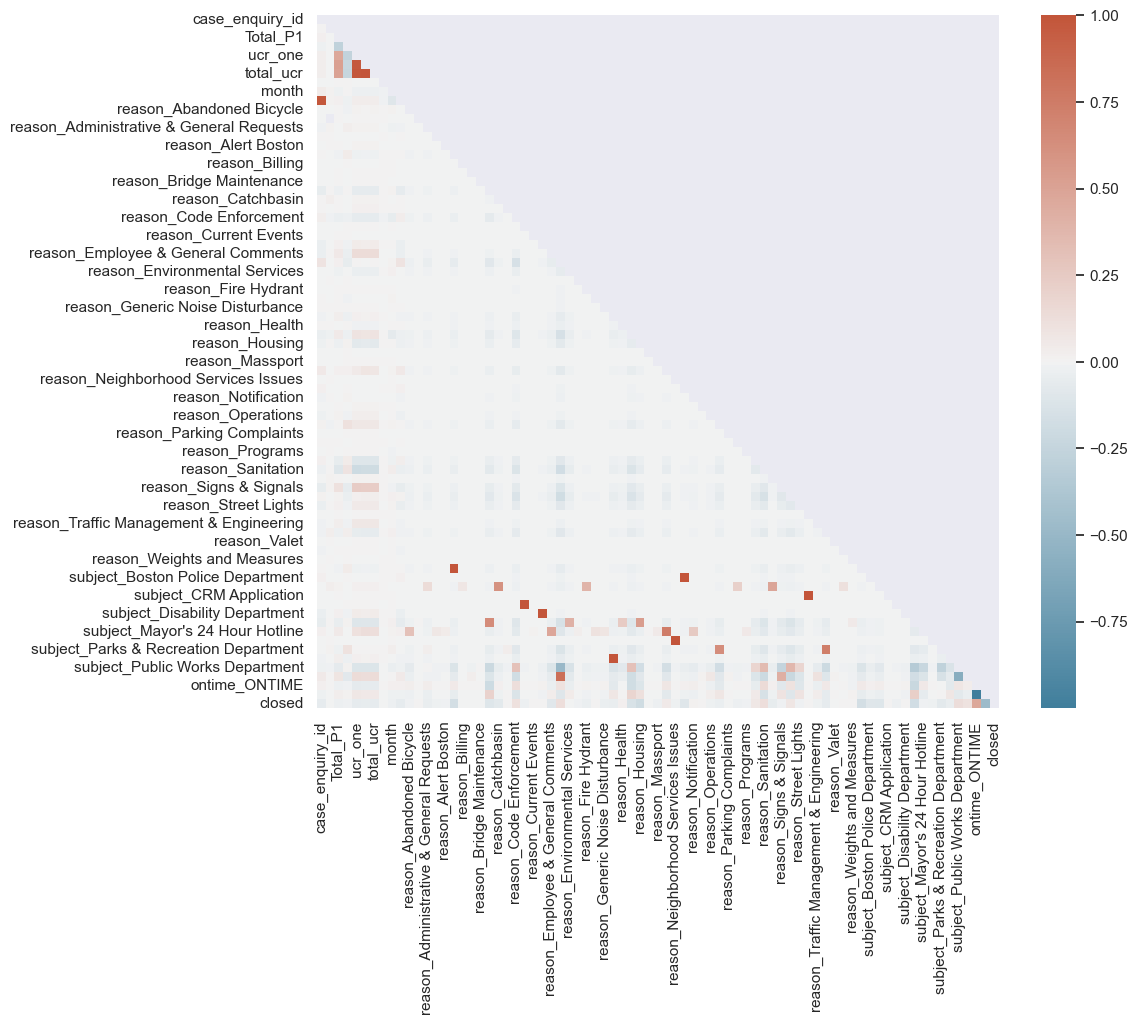

In [23]:
import matplotlib.pyplot as plt # visualization
import seaborn as sns

sns.set_theme(style="darkgrid")

# Compute a correlation matrix
corr = master_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap);


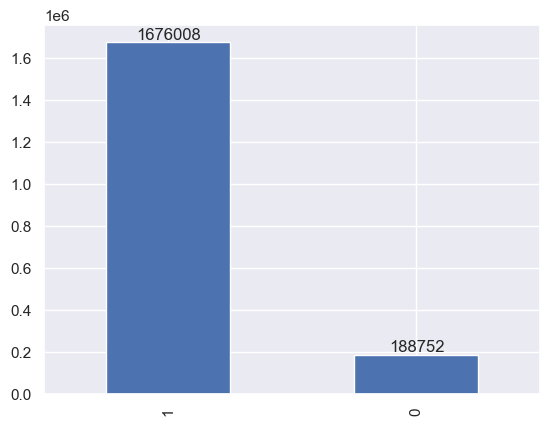

In [24]:
# we clearly have class imbalance
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(style="darkgrid")

status_count_fig = master_encoded['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



## Model Selection

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split



In [34]:
from sklearn.utils import resample

closed=master_encoded[master_encoded.closed==1]
open=master_encoded[master_encoded.closed==0]

# upsample minority
open_upsampled = resample(open
                            , replace=True # sample with replacement 
                            , n_samples=len(closed) # match number in majority class
                          , random_state=12022022) # set seed

# combine majority and upsampled minority
upsampled = pd.concat([closed, open_upsampled])

# check new class counts
upsampled.closed.value_counts()

1    1676008
0    1676008
Name: closed, dtype: int64

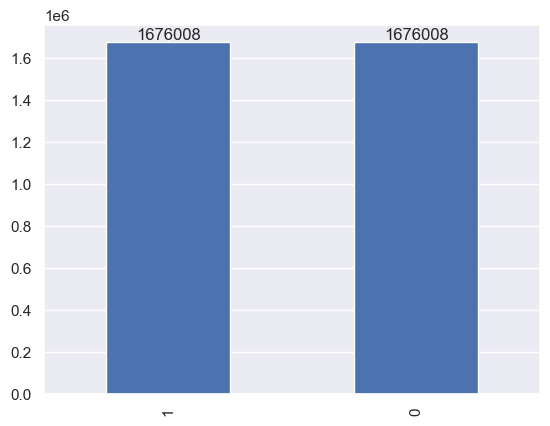

In [40]:
# now let's check our balance
status_count_fig = upsampled['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );

